In [1]:
import torch
from torchvision import models
from torchvision import transforms
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt
from visualization import attr_to_subplot
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

import attributions as attributions

# library that attacks a group of images with imperceptible noise
# https://github.com/Harry24k/adversarial-attacks-pytorch
import torchattacks
from patch_class import PatchAttacker
import torch

In [2]:
# standard ImageNet normalization
transform_normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

# standard ImageNet normalization
invert_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# transform data into format needed for resnet models. Expect 224x224 3-channel image
transform = transforms.Compose([
     transforms.Resize((224, 224)),
     transforms.CenterCrop(224),
     transforms.ToTensor()
])

default_cmap = LinearSegmentedColormap.from_list('custom blue',  [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')], N = 256)   

# returns the class of an image 
def getClass(input, model, device):
    # Add 4th dimension as required by model if not present
    if input.shape[0] != 1:
        input = input.unsqueeze(0)

    # calculate a prediction
    input = input.to(device)
    output = model(input)

    _, index = torch.max(output, 1)

    # open the class list so the detected class string can be returned for printing
    with open('class_maps/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    return index[0], classes[index[0]]


# create adversarially attacked images in batches
def attack_images(model, attack_type, image, label, device):
    torch.cuda.empty_cache()

    # setup attack object  
    if attack_type == "patch":
        mean_vec = [0.485, 0.456, 0.406]
        std_vec =  [0.229, 0.224, 0.225]
        attacker = PatchAttacker(model, mean_vec, std_vec, device, patch_size = 39, step_size=0.05, steps=250, image_size=224)

        true_class = label
        ground_truth = torch.zeros(1, 1000)
        ground_truth[0, true_class] = 1

        is_adv = False
        while not is_adv:
            adv_image, _ = attacker.perturb(image, ground_truth.to(device))
            with torch.no_grad():
                adv_output = model(adv_image).argmax(dim = 1).item()
                if adv_output != true_class:
                    is_adv = True

        return adv_image
    else:
        if attack_type == "Linf":
            atk = torchattacks.PGD(model, eps = 8/255, alpha = 2/255, steps = 50, random_start = True)
        elif attack_type == "L2":
            atk = torchattacks.PGDL2(model, eps = 1.0, alpha = 0.2, steps = 50, random_start = True) 

        atk.set_normalization_used(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        atk.set_mode_targeted_by_label(quiet = True) # do not show the message
        target_label = (label + 100) % 1000


        true_class = label
        label = label.to(torch.int64)

        is_adv = False
        while not is_adv:
            adv_image = atk(image, target_label)
            with torch.no_grad():
                adv_output = model(adv_image).argmax(dim = 1).item()
                if adv_output != true_class:
                    is_adv = True

        return adv_image

In [3]:
device = 'cuda:0'
model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to(device)

img = Image.open("imgs/sub.jpg")


trans_img = transform(img)
test_img = transform_normalize(trans_img).unsqueeze(0).to(device)

orig_class, name = getClass(test_img, model, device)
print(orig_class, name)

tensor(833, device='cuda:0') submarine


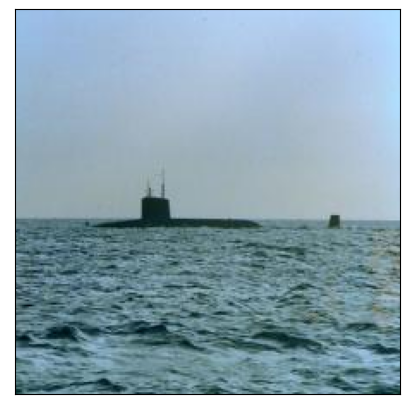

In [4]:
####### input image #######
fig, axs = plt.subplots(1, 1, figsize = (5, 5))

attr_to_subplot(trans_img, "", axs, original_image = True)                        
    
plt.show(fig)

utils.save_image(trans_img, "imgs/sub.jpg")

In [5]:
# attack loaded images
Linf_image = attack_images(model, "Linf", test_img, orig_class.unsqueeze(0), device)
L2_image = attack_images(model, "L2", test_img, orig_class.unsqueeze(0), device)
patch_image = attack_images(model, "patch", test_img, orig_class, device)

Linf_class, ac1 = getClass(Linf_image, model, device)
L2_class, ac2 = getClass(L2_image, model, device)
patch_class, ac3 = getClass(patch_image, model, device)
print(ac1, ac2, ac3)

cheeseburger cheeseburger shopping basket


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


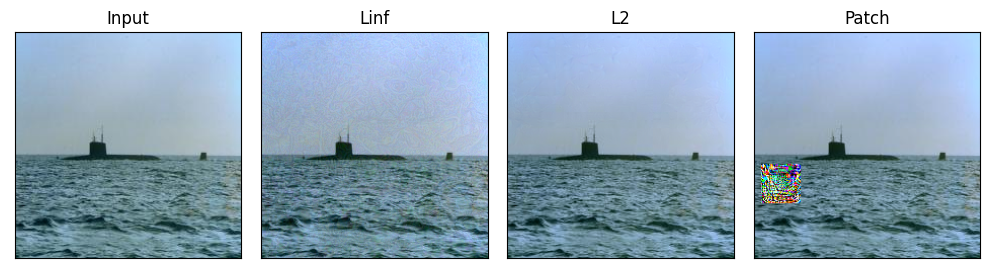

In [6]:
####### input image #######
fig, axs = plt.subplots(1, 4, figsize = (10, 5))

attr_to_subplot(trans_img, "Input", axs[0], original_image = True)                        
attr_to_subplot(invert_normalize(Linf_image), "Linf", axs[1], original_image = True)                        
attr_to_subplot(invert_normalize(L2_image), "L2", axs[2], original_image = True)                        
attr_to_subplot(invert_normalize(patch_image), "Patch", axs[3], original_image = True)                        
    
plt.tight_layout()

utils.save_image(invert_normalize(Linf_image), "imgs/Linf_image.jpg")
utils.save_image(invert_normalize(L2_image), "imgs/L2_image.jpg")
utils.save_image(invert_normalize(patch_image), "imgs/patch_image.jpg")

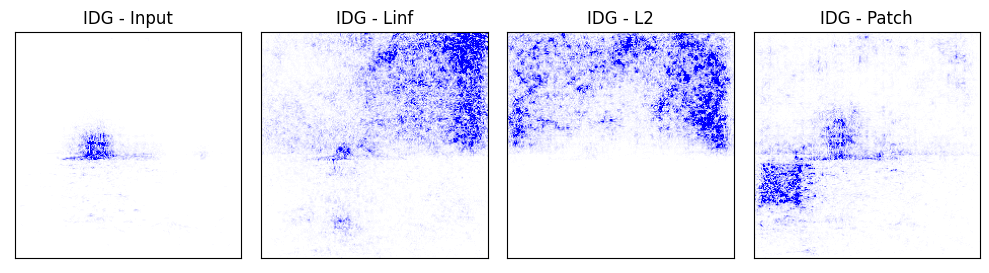

In [7]:
IDG_ben = attributions.IDG(invert_normalize(test_img.squeeze()), model, 50, 25, 0, device, orig_class)
IDG_Linf = attributions.IDG(invert_normalize(Linf_image.squeeze()), model, 50, 25, 0, device, Linf_class)
IDG_L2 = attributions.IDG(invert_normalize(L2_image.squeeze()), model, 50, 25, 0, device, L2_class)
IDG_patch = attributions.IDG(invert_normalize(patch_image.squeeze()), model, 50, 25, 0, device, patch_class)

fig, axs = plt.subplots(1, 4, figsize = (10, 5))
norm = "absolute"
attr_to_subplot(np.transpose(IDG_ben.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IDG - Input", axs[0], norm = norm)                        
attr_to_subplot(np.transpose(IDG_Linf.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IDG - Linf", axs[1], norm = norm)                        
attr_to_subplot(np.transpose(IDG_L2.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IDG - L2", axs[2], norm = norm)                        
attr_to_subplot(np.transpose(IDG_patch.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IDG - Patch", axs[3], norm = norm)                        
    
plt.tight_layout()

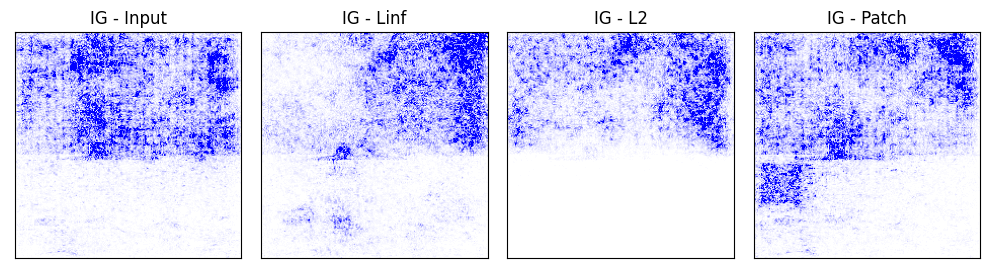

In [9]:
IG_ben = attributions.IGParallel(invert_normalize(test_img.squeeze()), model, 50, 25, 0, device, orig_class)
IG_Linf = attributions.IGParallel(invert_normalize(Linf_image.squeeze()), model, 50, 25, 0, device, Linf_class)
IG_L2 = attributions.IGParallel(invert_normalize(L2_image.squeeze()), model, 50, 25, 0, device, L2_class)
IG_patch = attributions.IGParallel(invert_normalize(patch_image.squeeze()), model, 50, 25, 0, device, patch_class)

fig, axs = plt.subplots(1, 4, figsize = (10, 5))
norm = "absolute"
attr_to_subplot(np.transpose(IG_ben.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IG - Input", axs[0], norm = norm)                        
attr_to_subplot(np.transpose(IG_Linf.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IG - Linf", axs[1], norm = norm)                        
attr_to_subplot(np.transpose(IG_L2.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IG - L2", axs[2], norm = norm)                        
attr_to_subplot(np.transpose(IG_patch.squeeze().detach().cpu().numpy(), (1, 2, 0)), "IG - Patch", axs[3], norm = norm)                        
    
plt.tight_layout()

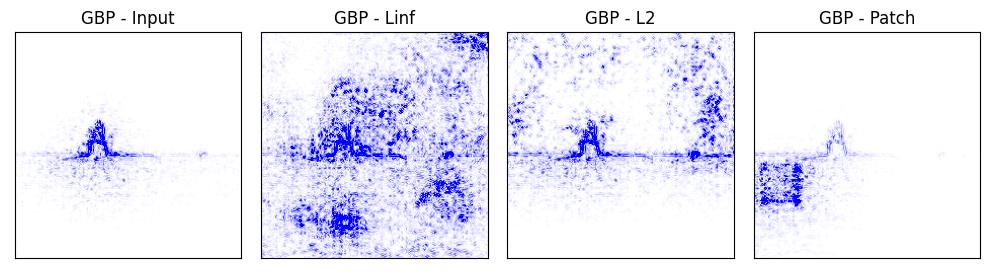

In [10]:
from modified_models import resnet
import captum.attr as attrMethods
import warnings

modified_model = resnet.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
modified_model = modified_model.eval()
modified_model.to(device)
GBP = attrMethods.GuidedBackprop(modified_model)

warnings.filterwarnings("ignore")

GBP_ben = GBP.attribute(test_img.to(device), target = orig_class)   
GBP_Linf = GBP.attribute(Linf_image.to(device), target = Linf_class)           
GBP_L2 = GBP.attribute(L2_image.to(device), target = L2_class)           
GBP_patch = GBP.attribute(patch_image.to(device), target = patch_class)           


fig, axs = plt.subplots(1, 4, figsize = (10, 5))
norm = "absolute"
attr_to_subplot(np.transpose(GBP_ben.squeeze().detach().cpu().numpy(), (1, 2, 0)), "GBP - Input", axs[0], norm = norm)                        
attr_to_subplot(np.transpose(GBP_Linf.squeeze().detach().cpu().numpy(), (1, 2, 0)), "GBP - Linf", axs[1], norm = norm)                        
attr_to_subplot(np.transpose(GBP_L2.squeeze().detach().cpu().numpy(), (1, 2, 0)), "GBP - L2", axs[2], norm = norm)                        
attr_to_subplot(np.transpose(GBP_patch.squeeze().detach().cpu().numpy(), (1, 2, 0)), "GBP - Patch", axs[3], norm = norm)                        
    
plt.tight_layout()